In [2]:
import numpy as np
from numba import njit
from scipy.spatial import cKDTree
import MITgcmutils as mit
from geopy.distance import  great_circle

import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from cartopy.mpl.ticker import LatitudeFormatter,LongitudeFormatter
import cmocean

In [3]:
@njit(cache=True)
def lonlat_to_xyz(lon, lat):
    """経度・緯度を3次元座標に変換"""
    lat, lon = np.deg2rad(lat), np.deg2rad(lon)  # 度からラジアンに変換
    x = np.cos(lat) * np.cos(lon)
    y = np.cos(lat) * np.sin(lon)
    z = np.sin(lat)
    return x, y, z


def calculate_top_l_indices_and_norms_ckdtree(XCYC1, XCYC2, l):
    """
    XCYC2 の各点に対して、XCYC1 からノルムが小さい順に l 点のインデックスとノルムを計算（cKDTree を使用）。
    """
    # XCYC1 を3次元座標に変換して平坦化
    m, n = XCYC1.shape[:2]
    flattened_XCYC1 = XCYC1.reshape(-1, 2)
    points_xyz = np.empty((flattened_XCYC1.shape[0], 3))
    for i in range(flattened_XCYC1.shape[0]):
        points_xyz[i] = lonlat_to_xyz(flattened_XCYC1[i, 0], flattened_XCYC1[i, 1])

    # cKDTree を構築
    tree = cKDTree(points_xyz)

    # 結果を格納する配列を初期化
    top_l_indices = np.zeros((XCYC2.shape[0], XCYC2.shape[1], l, 2), dtype=np.int32)
    top_l_norms = np.zeros((XCYC2.shape[0], XCYC2.shape[1], l))  # ノルムを格納

    # 各点を探索
    for i in range(XCYC2.shape[0]):
        for j in range(XCYC2.shape[1]):
            lon_query, lat_query = XCYC2[i, j, :]  # 経度、緯度を取得
            x_query, y_query, z_query = lonlat_to_xyz(lon_query, lat_query)

            # 最近傍探索
            distances, indices = tree.query([x_query, y_query, z_query], k=l)

            # インデックスを 2D の形状に変換
            if l == 1:  # l=1 の場合、スカラーが返るので処理を分岐
                indices = [indices]  # リスト化
                distances = [distances]  # リスト化

            unraveled_indices = np.unravel_index(indices, (m, n))

            for k in range(l):
                # インデックスを格納
                top_l_indices[i, j, k, :] = [unraveled_indices[0][k], unraveled_indices[1][k]]

                # ノルムを計算して格納
                top_l_norms[i, j, k] = distances[k]     


    return top_l_indices, top_l_norms



@njit(cache=True)
def regrid_data(XCYC1, XCYC2, top_l_indices, top_l_norms, data, p=2., l = 4):
    """
    XCYC2 の各点に対応する data の値を IDW（逆距離加重法）で内挿。

    Args:
        XCYC1 (ndarray): 元の座標データ (形状: [m, n, 2])
        XCYC2 (ndarray): 対応する座標データ (形状: [p, q, 2])
        top_l_indices (ndarray): 最近傍 l 点のインデックス (形状: [p, q, l, 2])
        top_l_norms (ndarray): 最近傍 l 点のノルム (形状: [p, q, l])
        data (ndarray): 元データ (例: SSS) (形状: [m, n])
        p (float): 重み計算のパラメータ（デフォルトは 1.）

    Returns:
        regridded_data (ndarray): 変換後の座標 XCYC2 上に内挿されたデータ (形状: [p, q])
    """
    if l >= top_l_indices.shape[2]:  # 最近傍点の数
        print("Warning: l is larger than the number of nearest neighbors available. Adjusting l to fit the data.")
        l = top_l_indices.shape[2]  # l を実際の最近傍点の数に合わせる  

    # 結果を格納する配列を初期化
    regridded_data = np.empty((XCYC2.shape[0], XCYC2.shape[1]))

    
    
    # データ内挿処理
    for i in range(XCYC2.shape[0]):  # XCYC2 の 1 軸目
        for j in range(XCYC2.shape[1]):  # XCYC2 の 2 軸目
            
            # 条件: 最近傍のノルムが閾値未満の場合、その値を直接代入
            # if top_l_norms[i, j, 0] < 1.e-10: #when unit is deg, worked well(to some extent).
            if top_l_norms[i, j, 0] < 1.e-4: #when unit is kilomerter, worked well.


                idx_x, idx_y = top_l_indices[i, j, 0]
                regridded_data[i, j] = data[idx_x, idx_y]
                continue
            
            # 各点の重み付けと加算
            weighted_sum = 0.0
            weight_total = 0.0
            for k in range(l):
                weight = top_l_norms[i, j, k] ** -p
                idx_x, idx_y = top_l_indices[i, j, k]
                weighted_sum += data[idx_x, idx_y] * weight
                weight_total += weight
            
            # 正規化（重みの合計で割る）
            regridded_data[i, j] = weighted_sum / (weight_total + 1.e-15) 


    return regridded_data



In [4]:
@njit(cache=True)
def interp_IDW_2d(XCYC1, XCYC2, top_l_indices, top_l_norms, data, p=2., l=4):
    return regrid_data(XCYC1, XCYC2, top_l_indices, top_l_norms, data, p, l)

@njit(cache=True)
def interp_IDW_3d(XCYC1, XCYC2, top_l_indices, top_l_norms, data, p=2., l=4):
    nt = data.shape[0]
    output = np.empty((nt, XCYC2.shape[0], XCYC2.shape[1]))
    for t in range(nt):
        output[t] = regrid_data(XCYC1, XCYC2, top_l_indices, top_l_norms, data[t], p, l)
    return output

@njit(cache=True)
def interp_IDW_4d(XCYC1, XCYC2, top_l_indices, top_l_norms, data, p=2., l=4):
    nt, nz = data.shape[:2]
    output = np.empty((nt, nz, XCYC2.shape[0], XCYC2.shape[1]))
    for t in range(nt):
        for z in range(nz):
            output[t, z] = regrid_data(XCYC1, XCYC2, top_l_indices, top_l_norms, data[t, z], p, l)
    return output       


# @njit(cache=True)
def interp_IDW(XCYC1, XCYC2, top_l_indices, top_l_norms, data, p=2., l=4):
    """
    Regrid data using regrid_data function, handling additional dimensions like time or depth.

    Args:
        XCYC1 (ndarray): Original coordinate data (shape: [m, n, 2]).
        XCYC2 (ndarray): Target coordinate data (shape: [p, q, 2]).
        top_l_indices (ndarray): Indices of nearest l points (shape: [p, q, l, 2]).
        top_l_norms (ndarray): Norms of nearest l points (shape: [p, q, l]).
        data (ndarray): Original data to be regridded (can have additional dimensions like time or depth).
        p (float): Weighting parameter for IDW (default: 2).

    Returns:
        regridded_data (ndarray): Regridded data on XCYC2 coordinates.
    """
    if data.ndim == 2 or (data.ndim == 3 and data.shape[0] == 1):
        # 2D data case
        return interp_IDW_2d(XCYC1, XCYC2, top_l_indices, top_l_norms, data, p, l)

    elif data.ndim == 3 or (data.ndim == 4 and data.shape[0] == 1):
        # 3D data case (e.g., depth or time dimension)
        return interp_IDW_3d(XCYC1, XCYC2, top_l_indices, top_l_norms, data, p, l)

    elif data.ndim == 4:
        # 4D data case (e.g., time and depth dimensions)
        regridded_data = np.empty((data.shape[0], data.shape[1], XCYC2.shape[0], XCYC2.shape[1]))
        return interp_IDW_4d(XCYC1, XCYC2, top_l_indices, top_l_norms, data, p, l)

    else:
        raise ValueError("Unsupported data dimensions. Expected 2D, 3D, or 4D data.")

In [5]:
@njit(cache=True)
def rotate_vector_to_EN_2d(U, V, AngleCS, AngleSN):
    """
    Rotate vector to east north direction for 2D data.
    
    Parameters
    ----------
    U: ndarray
        zonal vector component
    V: ndarray
        meridional vector component
    AngleCS: ndarray
        Cosine of angle of the grid center relative to the geographic direction
    AngleSN: ndarray
        Sine of angle of the grid center relative to the geographic direction

    Returns
    ----------
    uE: ndarray
        rotated zonal velocity
    vN: ndarray
        rotated meridional velocity

    """
    return AngleCS * U - AngleSN * V, AngleSN * U + AngleCS * V

@njit(cache=True)
def rotate_vector_to_EN_3d(U, V, AngleCS, AngleSN):
    """
    Rotate vector to east north direction for 3D data.
    
    Parameters
    ----------
    U: ndarray
        zonal vector component
    V: ndarray
        meridional vector component
    AngleCS: ndarray
        Cosine of angle of the grid center relative to the geographic direction
    AngleSN: ndarray
        Sine of angle of the grid center relative to the geographic direction

    Returns
    ----------
    uE: ndarray
        rotated zonal velocity
    vN: ndarray
        rotated meridional velocity

    """
    uE = np.empty_like(U)
    vN = np.empty_like(V)
    
    for i in range(U.shape[0]):
        uE[i], vN[i] = rotate_vector_to_EN_2d(U[i], V[i], AngleCS, AngleSN)
    
    return uE, vN

@njit(cache=True)
def rotate_vector_to_EN_4d(U, V, AngleCS, AngleSN): 
    """
    Rotate vector to east north direction for 4D data.
    
    Parameters
    ----------
    U: ndarray
        zonal vector component
    V: ndarray
        meridional vector component
    AngleCS: ndarray
        Cosine of angle of the grid center relative to the geographic direction
    AngleSN: ndarray
        Sine of angle of the grid center relative to the geographic direction

    Returns
    ----------
    uE: ndarray
        rotated zonal velocity
    vN: ndarray
        rotated meridional velocity

    """
    uE = np.empty_like(U)
    vN = np.empty_like(V)
    
    for i in range(U.shape[0]):
        for j in range(U.shape[1]):
            uE[i, j], vN[i, j] = rotate_vector_to_EN_2d(U[i, j], V[i, j], AngleCS, AngleSN)
    
    return uE, vN


@njit(cache=True)    
def rotate_vector_to_EN(U, V, AngleCS, AngleSN):
        """
        rotate vector to east north direction.
        Assumes that AngleCS and AngleSN are already of same dimension as V and U (i.e. already interpolated to cell center)

        Parameters
        ----------
        U:
            zonal vector component
        V:
            meridional vector component
        AngleCS:
            Cosine of angle of the grid center relative to the geographic direction
        AngleSN:
            Sine of angle of the grid center relative to the geographic direction

        Returns
        ----------
        uE: xarray Dataarray
            rotated zonal velocity
        vN: xarray Dataarray
            rotated meridional velocity

        """ 
        if U.ndim != V.ndim:
            raise ValueError("U and V must have the same number of dimensions.")    
        
        
        # Check if the input arrays are 2D, 3D, or 4D
        if U.ndim == 2 or (U.ndim == 3 and U.shape[0] == 1):
            #rotate the vectors:
            return rotate_vector_to_EN_2d(U, V, AngleCS, AngleSN)

        elif U.ndim == 3 or (U.ndim == 4 and U.shape[0] == 1):
            #rotate the vectors:
            return rotate_vector_to_EN_3d(U, V, AngleCS, AngleSN)
        elif U.ndim == 4:
            #rotate the vectors:
            return rotate_vector_to_EN_4d(U, V, AngleCS, AngleSN)
        else:
            raise ValueError("Unsupported data dimensions. Expected 2D, 3D, or 4D data.")



In [6]:
fileloc_rank0='/home/tsuribeh/MITgcm/cases_tsuribeh_master/cpl_aim+ocn/rank_0/'
fileloc_rank1='/home/tsuribeh/MITgcm/cases_tsuribeh_master/cpl_aim+ocn/rank_1/'
fileloc_rank2='/home/tsuribeh/MITgcm/cases_tsuribeh_master/cpl_aim+ocn/rank_2/'

# fileloc_rank1='/home/tsuribeh/MITgcm/cases_tsuribeh_master/cpl_aim+ocn/rank_1_test/'
# fileloc_rank2='/home/tsuribeh/MITgcm/cases_tsuribeh_master/cpl_aim+ocn/rank_2_test/'

ADAY = 60.*60.*24. #[s]
AMONTH = ADAY*30.
AYEAR = AMONTH*12.

deltaTclock = 43200#[s] 


In [7]:
XC = mit.rdmds(fileloc_rank1+'XC')
XG = mit.rdmds(fileloc_rank1+'XG')

YC = mit.rdmds(fileloc_rank1+'YC')
YG = mit.rdmds(fileloc_rank1+'YG')

XCYC = np.stack([XC,YC],axis=2)
XGYC = np.stack([XG,YC],axis=2)
XCYG = np.stack([XC,YG],axis=2)



In [106]:
DXC = mit.rdmds(fileloc_rank1+'DXC')
DYC = mit.rdmds(fileloc_rank1+'DYC')
DRF = mit.rdmds(fileloc_rank1+'DRF')
hFacC = mit.rdmds(fileloc_rank1+'hFacC')
DVC = DXC*DYC*DRF*hFacC

RC_ocn = mit.rdmds(fileloc_rank1+'RC')
RF_ocn = mit.rdmds(fileloc_rank1+'RF')

DXC_atm = mit.rdmds(fileloc_rank2+'DXC')
DYC_atm = mit.rdmds(fileloc_rank2+'DYC')
DRF_atm = mit.rdmds(fileloc_rank2+'DRF')
hFacC_atm = mit.rdmds(fileloc_rank2+'hFacC')
DVC_atm = DXC_atm*DYC_atm*DRF_atm*hFacC_atm


AngleCS = mit.rdmds(fileloc_rank1+'AngleCS') #cosine of grid orientation angle relative to Geographic direction at cell center: alpha=(Eastward_dir,grid_uVel_dir)=(North_d,vVel_d)
AngleSN = mit.rdmds(fileloc_rank1+'AngleSN') #sine   of grid orientation angle relative to Geographic direction at cell center: alpha=(Eastward_dir,grid_uVel_dir)=(North_d,vVel_d)
u2zonDir = mit.rdmds(fileloc_rank1+'U2zonDir') #cosine of grid orientation angle at U point location
v2zonDir = mit.rdmds(fileloc_rank1+'V2zonDir') #minus sine of  orientation angle at V point location



lon__ = np.linspace(-180,180,180+1)
lat__ = np.linspace(-90,90,90+1)
lon_ = (lon__[1:]+lon__[:-1])*0.5  #cell center
lat_ = (lat__[1:] + lat__[:-1])*0.5
lon,lat = np.meshgrid(lon_,lat_)

lonlat = np.stack([lon,lat],axis=2)  #lonlat is cell center coordinates





indices_XGYC_XCYC, norm_XGYC_XCYC = calculate_top_l_indices_and_norms_ckdtree(XGYC, XCYC, 16) #Uの補完に用いる
indices_XCYG_XCYC, norm_XCYG_XCYC = calculate_top_l_indices_and_norms_ckdtree(XGYC, XCYC, 16) #Vの補完に用いる



indices_XGYC_lonlat, norm_XGYC_lonlat = calculate_top_l_indices_and_norms_ckdtree(XGYC, lonlat, 16)
indices_XCYG_lonlat, norm_XCYG_lonlat = calculate_top_l_indices_and_norms_ckdtree(XCYG, lonlat, 16)
indices_XCYC_lonlat, norm_XCYC_lonlat = calculate_top_l_indices_and_norms_ckdtree(XCYC, lonlat, 16)

# dataTime= AMONTH*12*430
# startTime= AMONTH*12*250

dataTime= AMONTH*12*400
startTime= AMONTH*12*0



iter_atm = np.arange(startTime/deltaTclock, dataTime/deltaTclock+1, AMONTH*12*10/deltaTclock)
iter_ocn = np.arange(startTime/deltaTclock, dataTime/deltaTclock+1, AMONTH*12*10/deltaTclock)
# iter_ocn = np.arange(0, 5+1, 5)
# iter_atm = np.arange(0, 40+1, 40)
iter_ocnTave =iter_ocn[1:]
iter_atmTave =iter_atm[1:]


In [107]:
lat_distance = np.empty_like(lat)
lon_distance = np.empty_like(lon)

for j in range(lat.shape[0]):
    for i in range(lon.shape[1]):
        # print('i:',i)
        lat_distance[j,i] = great_circle((lat__[j+1],lon_[i]),(lat__[j],lon_[i])).meters 
        lon_distance[j,i] = great_circle((lat_[j],lon__[i+1]),(lat_[j],lon__[i])).meters
    # print('j:',j)
    


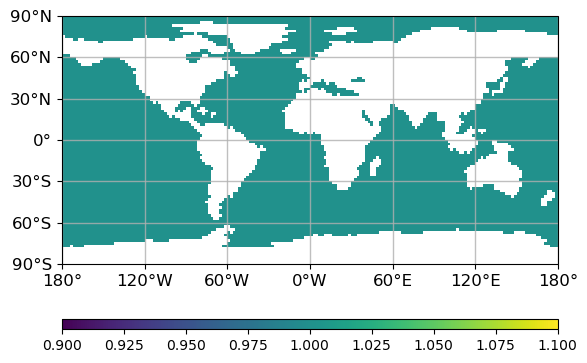

In [108]:
# landmask = mit.readbin(fileloc_rank2+'landFrc.Ex2_CTRL_CS32.bin', (32,192),dataprec='float64')
landmask= np.where(DVC==0., np.nan, 1.)  # DVCが0のところはnan(land), それ以外は1.(ocn)にする

landmask_regrid = interp_IDW(XCYC, lonlat, indices_XCYC_lonlat, norm_XCYC_lonlat, landmask, p=0., l=2
                             )

# landmask_regrid[landmask_regrid == 0.] = np.nan

fig = plt.figure()
ax = plt.axes(projection=ccrs.PlateCarree())
cf = ax.pcolormesh(lon,lat, landmask_regrid[1]
                   )


#グリッドと軸目盛を描く緯度経度を設定するための配列
dlon,dlat=60,30
xticks=np.arange(-180,180.1,dlon)
yticks=np.arange(-90,90.1,dlat)

#グリッド線を引く
gl = ax.gridlines(crs=ccrs.PlateCarree()
         , draw_labels=False
         , linewidth=1, alpha=0.8)
gl.xlocator = mticker.FixedLocator(xticks)    
gl.ylocator = mticker.FixedLocator(yticks)
#目盛を描く緯度経度の値を設定
ax.set_xticks(xticks,crs=ccrs.PlateCarree())
ax.set_yticks(yticks,crs=ccrs.PlateCarree())

# 目盛の表示形式を度数表記にする    
latfmt=LatitudeFormatter()
lonfmt=LongitudeFormatter(zero_direction_label=True)
ax.xaxis.set_major_formatter(lonfmt)
ax.yaxis.set_major_formatter(latfmt)
#目盛のサイズを指定
ax.axes.tick_params(labelsize=12)

plt.colorbar(cf, ax=ax, orientation='horizontal', aspect=50,)


In [109]:

DVCocn_lonlat = lon_distance* lat_distance* DRF   
DVCatm_lonlat = lon_distance* lat_distance* DRF_atm  

<>:19: SyntaxWarning: invalid escape sequence '\e'
<>:19: SyntaxWarning: invalid escape sequence '\e'
/tmp/ipykernel_60644/516281900.py:19: SyntaxWarning: invalid escape sequence '\e'
  cb.set_label("$\eta$ [m]")


-5.642050317581592

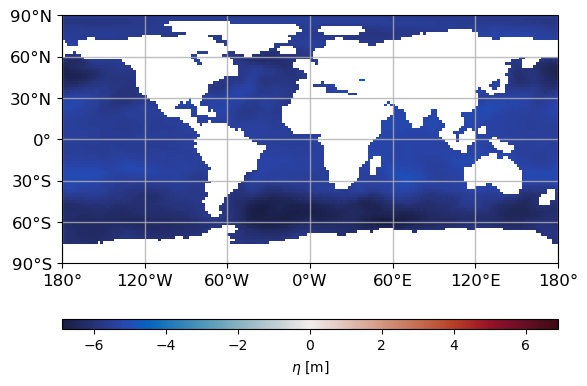

In [110]:
Eta_ocn = mit.rdmds(fileloc_rank1 + 'Eta',list(iter_ocn))*landmask[0] #iter_ocn 時間方向の長さを持ったnumpy配列

# dmax = 1.


Eta_regrid = interp_IDW(XCYC, lonlat, indices_XCYC_lonlat, norm_XCYC_lonlat, Eta_ocn, p=1., l=4)

fig = plt.figure()
ax = plt.axes(projection=ccrs.PlateCarree())
plot_data = Eta_regrid[-1]
dmax = max(np.nanmax(plot_data), -np.nanmin(plot_data))
cf = ax.pcolormesh(lon,lat, plot_data, vmin=-dmax, vmax= dmax
                   , cmap=cmocean.cm.balance
                   )
# Eta_regrid[landmask_regrid != 0.] = np.nan

# カラーバーを追加
cb = fig.colorbar(cf, ax=ax, orientation="horizontal", aspect=50)
cb.set_label("$\eta$ [m]")

#グリッドと軸目盛を描く緯度経度を設定するための配列
dlon,dlat=60,30
xticks=np.arange(-180,180.1,dlon)
yticks=np.arange(-90,90.1,dlat)

#グリッド線を引く
gl = ax.gridlines(crs=ccrs.PlateCarree()
         , draw_labels=False
         , linewidth=1, alpha=0.8)
gl.xlocator = mticker.FixedLocator(xticks)    
gl.ylocator = mticker.FixedLocator(yticks)
#目盛を描く緯度経度の値を設定
ax.set_xticks(xticks,crs=ccrs.PlateCarree())
ax.set_yticks(yticks,crs=ccrs.PlateCarree())

# 目盛の表示形式を度数表記にする    
latfmt=LatitudeFormatter()
lonfmt=LongitudeFormatter(zero_direction_label=True)
ax.xaxis.set_major_formatter(lonfmt)
ax.yaxis.set_major_formatter(latfmt)
#目盛のサイズを指定
ax.axes.tick_params(labelsize=12)

#mask land
# mask = np.ones_like(plot_data)*np.nan
# mask[landmask_regrid[0] != 1.] = 0.5
# ax.pcolormesh(lon, lat, mask, cmap='binary',vmax=1.0, vmin=0.0)


np.nansum(DXC*DYC*landmask*Eta_ocn[-1])/np.nansum(DXC*DYC*landmask)


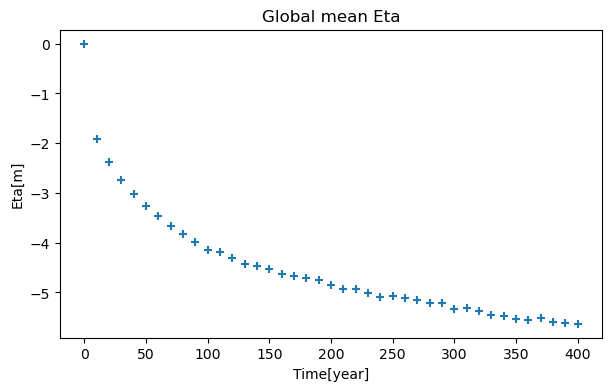

In [111]:

np.sum(DVC[0]*Eta_ocn[-1])/np.sum(DVC[0])
meanEta =np.nansum(DVC[0]*Eta_ocn, axis=(1,2))/np.nansum(DVC[0])


fig=plt.figure(figsize=(7,4))
ax= fig.add_subplot(111)
ax.scatter(iter_ocn/(AYEAR/deltaTclock), meanEta, marker='+')
ax.set_title('Global mean Eta')
ax.set_xlabel('Time[year]')
ax.set_ylabel('Eta[m]')

plt.show()


In [112]:
Temp_ocn = mit.rdmds(fileloc_rank1 + 'T',list(iter_ocn))*landmask
Temp_atm = mit.rdmds(fileloc_rank2 + 'T',list(iter_atm))


<>:16: SyntaxWarning: invalid escape sequence '\e'
<>:16: SyntaxWarning: invalid escape sequence '\e'
/tmp/ipykernel_60644/2990685456.py:16: SyntaxWarning: invalid escape sequence '\e'
  cb.set_label("$\eta$ [m]")


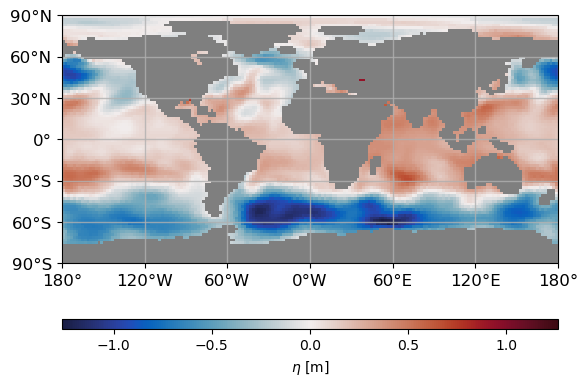

In [113]:

plot_data = interp_IDW(XCYC, lonlat, indices_XCYC_lonlat, norm_XCYC_lonlat, Eta_ocn[-1] - meanEta[-1], p=1., l=4)

dmax = max(np.nanmax(plot_data), -np.nanmin(plot_data))
# dmax = 1.

# interpolator_Eta = tri.LinearTriInterpolator(triang, Eta_ocn.flatten())


fig = plt.figure()
ax = plt.axes(projection=ccrs.PlateCarree())
cf = ax.pcolormesh(lon,lat, plot_data, vmin=-dmax, vmax= dmax, cmap=cmocean.cm.balance
                   )

# カラーバーを追加
cb = fig.colorbar(cf, ax=ax, orientation="horizontal", aspect=50)
cb.set_label("$\eta$ [m]")

#グリッドと軸目盛を描く緯度経度を設定するための配列
dlon,dlat=60,30
xticks=np.arange(-180,180.1,dlon)
yticks=np.arange(-90,90.1,dlat)

#グリッド線を引く
gl = ax.gridlines(crs=ccrs.PlateCarree()
         , draw_labels=False
         , linewidth=1, alpha=0.8)
gl.xlocator = mticker.FixedLocator(xticks)    
gl.ylocator = mticker.FixedLocator(yticks)
#目盛を描く緯度経度の値を設定
ax.set_xticks(xticks,crs=ccrs.PlateCarree())
ax.set_yticks(yticks,crs=ccrs.PlateCarree())

# 目盛の表示形式を度数表記にする    
latfmt=LatitudeFormatter()
lonfmt=LongitudeFormatter(zero_direction_label=True)
ax.xaxis.set_major_formatter(lonfmt)
ax.yaxis.set_major_formatter(latfmt)
#目盛のサイズを指定
ax.axes.tick_params(labelsize=12)

#mask land
mask = np.ones_like(plot_data)*np.nan
mask[np.isnan(plot_data)] = 0.5
ax.pcolormesh(lon, lat, mask, cmap='binary',vmax=1.0, vmin=0.0)


<>:11: SyntaxWarning: invalid escape sequence '\c'
<>:11: SyntaxWarning: invalid escape sequence '\c'
/tmp/ipykernel_60644/419409397.py:11: SyntaxWarning: invalid escape sequence '\c'
  ax.set_ylabel('Pot. temperature[$^\circ$C]')


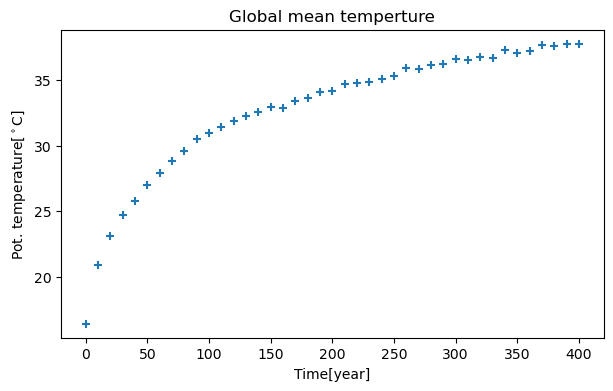

In [114]:
TatmDVC = Temp_atm*DVC_atm

meanT_atm = np.sum(TatmDVC, axis=(2,3))/DVC_atm.sum(axis=(1,2))


fig=plt.figure(figsize=(7,4))
ax= fig.add_subplot(111)
ax.scatter(iter_ocn*deltaTclock/AYEAR, meanT_atm[:,0]-273.15, marker='+')
ax.set_title('Global mean temperture')
ax.set_xlabel('Time[year]')
ax.set_ylabel('Pot. temperature[$^\circ$C]')

plt.show()




<>:11: SyntaxWarning: invalid escape sequence '\c'
<>:11: SyntaxWarning: invalid escape sequence '\c'
/tmp/ipykernel_60644/2890242559.py:11: SyntaxWarning: invalid escape sequence '\c'
  ax.set_ylabel('Pot. temperature[$^\circ$C]')


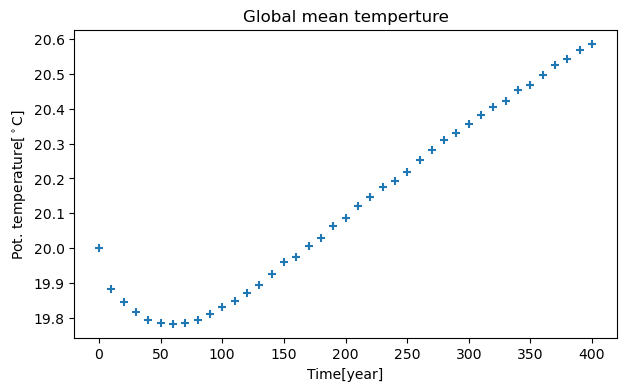

In [115]:
TocnDVC = Temp_ocn*DVC

meanT = np.nansum(TocnDVC, axis=(1,2,3))/np.nansum(DVC)


fig=plt.figure(figsize=(7,4))
ax= fig.add_subplot(111)
ax.scatter(iter_ocn/(AYEAR/deltaTclock), meanT, marker='+')
ax.set_title('Global mean temperture')
ax.set_xlabel('Time[year]')
ax.set_ylabel('Pot. temperature[$^\circ$C]')

plt.show()




In [116]:
Tatm_regrid= interp_IDW(XCYC, lonlat, indices_XCYC_lonlat, norm_XCYC_lonlat, Temp_atm, p=1., l=4)

Tocn_regrid= interp_IDW(XCYC, lonlat, indices_XCYC_lonlat, norm_XCYC_lonlat, Temp_ocn, p=1., l=4)


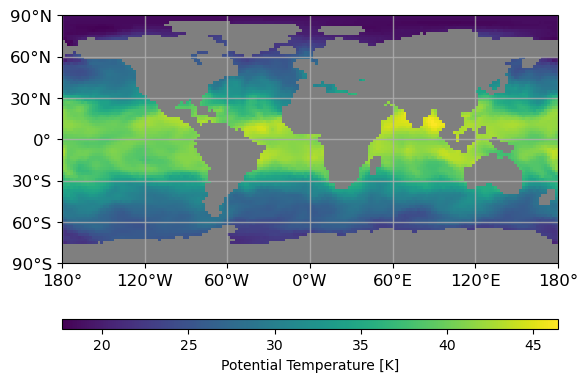

In [117]:
fig = plt.figure()
ax = plt.axes(projection=ccrs.PlateCarree())
d=0
plot_data =Tocn_regrid[-1,d]
cf = ax.pcolormesh(lon,lat, plot_data
                   )

# カラーバーを追加
cb = fig.colorbar(cf, ax=ax, orientation="horizontal", aspect=50)
cb.set_label("Potential Temperature [K]")

#グリッドと軸目盛を描く緯度経度を設定するための配列
dlon,dlat=60,30
xticks=np.arange(-180,180.1,dlon)
yticks=np.arange(-90,90.1,dlat)

#グリッド線を引く
gl = ax.gridlines(crs=ccrs.PlateCarree()
         , draw_labels=False
         , linewidth=1, alpha=0.8)
gl.xlocator = mticker.FixedLocator(xticks)    
gl.ylocator = mticker.FixedLocator(yticks)
#目盛を描く緯度経度の値を設定
ax.set_xticks(xticks,crs=ccrs.PlateCarree())
ax.set_yticks(yticks,crs=ccrs.PlateCarree())

# 目盛の表示形式を度数表記にする    
latfmt=LatitudeFormatter()
lonfmt=LongitudeFormatter(zero_direction_label=True)
ax.xaxis.set_major_formatter(lonfmt)
ax.yaxis.set_major_formatter(latfmt)
#目盛のサイズを指定
ax.axes.tick_params(labelsize=12)

#mask land
mask = np.ones_like(plot_data)*np.nan
mask[np.isnan(plot_data)] = 0.5
ax.pcolormesh(lon, lat, mask, cmap='binary',vmax=1.0, vmin=0.0)


In [118]:
Tocn_zonalmean = np.nansum(Tocn_regrid*DVCocn_lonlat, axis=3)/ np.nansum(DVCocn_lonlat*landmask_regrid, axis=2)

/tmp/ipykernel_60644/2185781728.py:1: RuntimeWarning: invalid value encountered in divide
  Tocn_zonalmean = np.nansum(Tocn_regrid*DVCocn_lonlat, axis=3)/ np.nansum(DVCocn_lonlat*landmask_regrid, axis=2)


<>:8: SyntaxWarning: invalid escape sequence '\c'
<>:8: SyntaxWarning: invalid escape sequence '\c'
/tmp/ipykernel_60644/2001760297.py:8: SyntaxWarning: invalid escape sequence '\c'
  ax.set_ylabel('Potential Temperature [$^\circ$C]')


Text(0.5, 1.0, 'Zonal mean potential temperature')

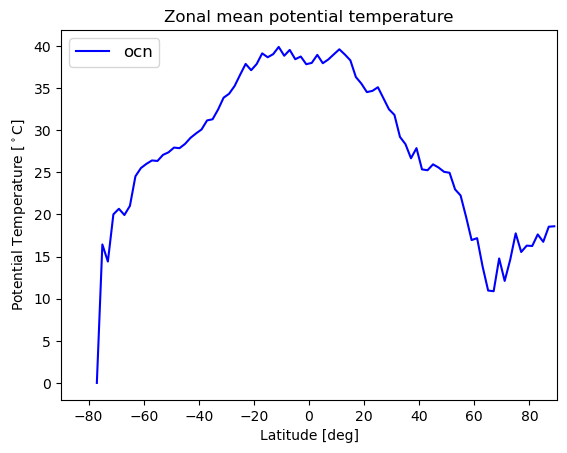

In [119]:
fig = plt.figure()
ax = plt.axes()
ax.plot(lat_, Tocn_zonalmean[-1,0], label='ocn', color='blue')
# ax.plot(lat_, Tatm_zonalmean[0]-273.15, label='atm', color='red')    
ax.legend( loc='upper left', fontsize=12)
ax.set_xlim(-90, 90)
ax.set_xlabel('Latitude [deg]')
ax.set_ylabel('Potential Temperature [$^\circ$C]')
ax.set_title('Zonal mean potential temperature')

In [120]:
Socn = mit.rdmds(fileloc_rank1 + 'S',list(iter_ocn))
Satm = mit.rdmds(fileloc_rank2 + 'S',list(iter_atm))

In [121]:
Socn_regrid = interp_IDW(XCYC, lonlat, indices_XCYC_lonlat, norm_XCYC_lonlat, Socn, p=1., l=4)*landmask_regrid
Satm_regrid = interp_IDW(XCYC, lonlat, indices_XCYC_lonlat, norm_XCYC_lonlat, Satm, p=1., l=4)

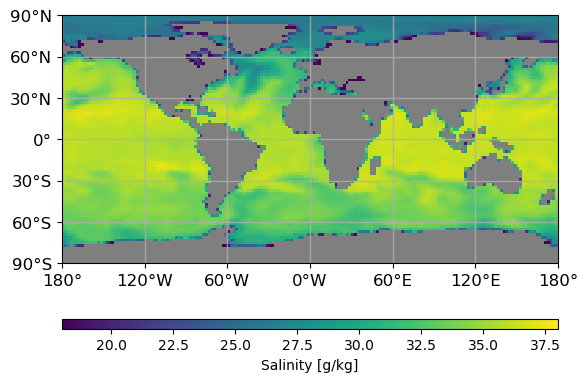

In [122]:
fig = plt.figure()
ax = plt.axes(projection=ccrs.PlateCarree())
iter_idx = -1
depth_idx = 0
plot_data = Socn_regrid[iter_idx,depth_idx]
cf = ax.pcolormesh(lon,lat, plot_data, vmin=18., vmax=38.
                   )

# カラーバーを追加
cb = fig.colorbar(cf, ax=ax, orientation="horizontal", aspect=50)
cb.set_label("Salinity [g/kg]")

#グリッドと軸目盛を描く緯度経度を設定するための配列
dlon,dlat=60,30
xticks=np.arange(-180,180.1,dlon)
yticks=np.arange(-90,90.1,dlat)

#グリッド線を引く
gl = ax.gridlines(crs=ccrs.PlateCarree()
         , draw_labels=False
         , linewidth=1, alpha=0.8)
gl.xlocator = mticker.FixedLocator(xticks)    
gl.ylocator = mticker.FixedLocator(yticks)
#目盛を描く緯度経度の値を設定
ax.set_xticks(xticks,crs=ccrs.PlateCarree())
ax.set_yticks(yticks,crs=ccrs.PlateCarree())

# 目盛の表示形式を度数表記にする    
latfmt=LatitudeFormatter()
lonfmt=LongitudeFormatter(zero_direction_label=True)
ax.xaxis.set_major_formatter(lonfmt)
ax.yaxis.set_major_formatter(latfmt)
#目盛のサイズを指定
ax.axes.tick_params(labelsize=12)

#mask land
mask = np.ones_like(plot_data)*np.nan
mask[np.isnan(plot_data)] = 0.5
ax.pcolormesh(lon, lat, mask, cmap='binary',vmax=1.0, vmin=0.0)


In [123]:
Uocn = mit.rdmds(fileloc_rank1 + 'U',list(iter_ocn))
Vocn = mit.rdmds(fileloc_rank1 + 'V',list(iter_ocn))
Wocn = mit.rdmds(fileloc_rank1 + 'W',list(iter_ocn))

Uatm = mit.rdmds(fileloc_rank2 + 'U',list(iter_atm))
Vatm = mit.rdmds(fileloc_rank2 + 'V',list(iter_atm))
Watm = mit.rdmds(fileloc_rank2 + 'W',list(iter_atm))


In [124]:

Wocn_regrid = interp_IDW(XCYC, lonlat, indices_XCYC_lonlat, norm_XCYC_lonlat, Wocn, p=1., l=4)
Watm_regrid = interp_IDW(XCYC, lonlat, indices_XCYC_lonlat, norm_XCYC_lonlat, Watm, p=1., l=4)

In [125]:
# Add ocean bottom layer to Wocn and Watm before averaging
WFocn = np.concatenate([Wocn, np.zeros((Wocn.shape[0],1, Wocn.shape[2], Wocn.shape[3]) )], axis=1)
WCocn = WFocn[:,1:,:,:] + WFocn[:,:-1,:,:] # Add Wocn to the bottom layer of WFocn

WFatm = np.concatenate([Watm, np.zeros((Watm.shape[0],1, Watm.shape[2], Watm.shape[3]) )], axis=1)
WCatm = WFatm[:,1:,:] + WFatm[:,:-1,:,:] # Add Watm to the bottom layer of WFatm       


In [126]:
# Interpolate ocean vectors to the grid center
Uocn =interp_IDW(XGYC,XCYC,indices_XGYC_XCYC, norm_XGYC_XCYC, Uocn)
Vocn = interp_IDW(XCYG,XCYC,indices_XCYG_XCYC, norm_XCYG_XCYC, Vocn)
# Rotate the ocean vectors to east-north direction
UEocn, VNocn = rotate_vector_to_EN(Uocn, Vocn, AngleCS, AngleSN)

# Interpolate ocean velocity to lon-lat grid
Uocn_regrid = interp_IDW(XCYC, lonlat, indices_XCYC_lonlat, norm_XCYC_lonlat, UEocn)*landmask_regrid
Vocn_regrid = interp_IDW(XCYC, lonlat, indices_XCYC_lonlat, norm_XCYC_lonlat, VNocn)*landmask_regrid
Wocn_regrid = interp_IDW(XCYC, lonlat, indices_XCYC_lonlat, norm_XCYC_lonlat, WCocn)*landmask_regrid

# Interpolate atmospheric vectors to the grid center
Uatm = interp_IDW(XGYC,XCYC,indices_XGYC_XCYC, norm_XGYC_XCYC, Uatm)
Vatm = interp_IDW(XCYG,XCYC,indices_XCYG_XCYC, norm_XCYG_XCYC, Vatm)
# Rotate the atmospheric vectors to east-north direction
UEatm, VNatm = rotate_vector_to_EN(Uatm, Vatm, AngleCS, AngleSN)
# Interpolate atmospheric velocity to lon-lat grid
Uatm_regrid = interp_IDW(XCYC, lonlat, indices_XCYC_lonlat, norm_XCYC_lonlat, UEatm)
Vatm_regrid = interp_IDW(XCYC, lonlat, indices_XCYC_lonlat, norm_XCYC_lonlat, VNatm)
Watm_regrid = interp_IDW(XCYC, lonlat, indices_XCYC_lonlat, norm_XCYC_lonlat, WCatm)    

# Calculate zonal mean of ocean velocity
Uocn_zonalmean = np.nansum(Uocn_regrid*DVCocn_lonlat, axis=3)/ np.nansum(DVCocn_lonlat*landmask_regrid, axis=2)
Vocn_zonalmean = np.nansum(Vocn_regrid*DVCocn_lonlat, axis=3)/ np.nansum(DVCocn_lonlat*landmask_regrid, axis=2)
Wocn_zonalmean = np.nansum(Wocn_regrid*DVCocn_lonlat, axis=3)/ np.nansum(DVCocn_lonlat*landmask_regrid, axis=2)     
# Calculate zonal mean of atmospheric velocity
Uatm_zonalmean = np.nansum(Uatm_regrid*DVCatm_lonlat, axis=3)/ np.nansum(DVCatm_lonlat, axis=2)
Vatm_zonalmean = np.nansum(Vatm_regrid*DVCatm_lonlat, axis=3)/ np.nansum(DVCatm_lonlat, axis=2)
Watm_zonalmean = np.nansum(Watm_regrid*DVCatm_lonlat, axis=3)/ np.nansum(DVCatm_lonlat, axis=2) 


/tmp/ipykernel_60644/3206918516.py:23: RuntimeWarning: invalid value encountered in divide
  Uocn_zonalmean = np.nansum(Uocn_regrid*DVCocn_lonlat, axis=3)/ np.nansum(DVCocn_lonlat*landmask_regrid, axis=2)
/tmp/ipykernel_60644/3206918516.py:24: RuntimeWarning: invalid value encountered in divide
  Vocn_zonalmean = np.nansum(Vocn_regrid*DVCocn_lonlat, axis=3)/ np.nansum(DVCocn_lonlat*landmask_regrid, axis=2)
/tmp/ipykernel_60644/3206918516.py:25: RuntimeWarning: invalid value encountered in divide
  Wocn_zonalmean = np.nansum(Wocn_regrid*DVCocn_lonlat, axis=3)/ np.nansum(DVCocn_lonlat*landmask_regrid, axis=2)


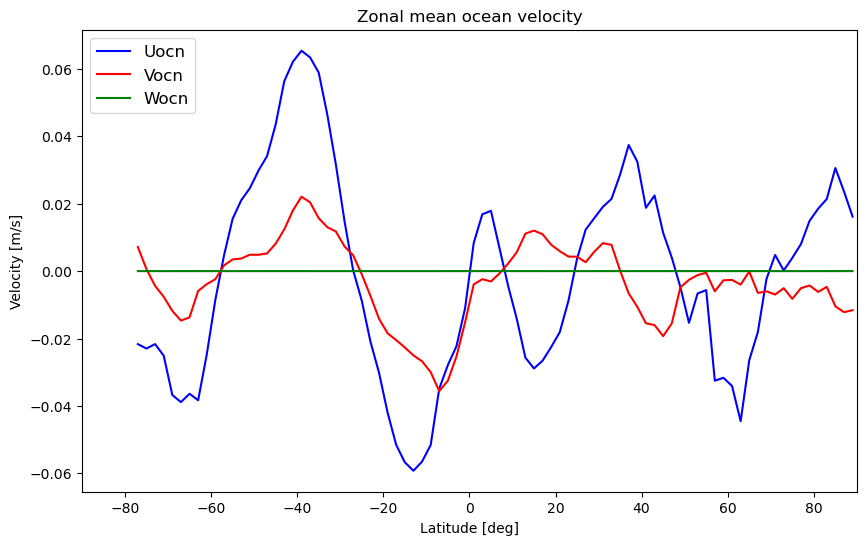

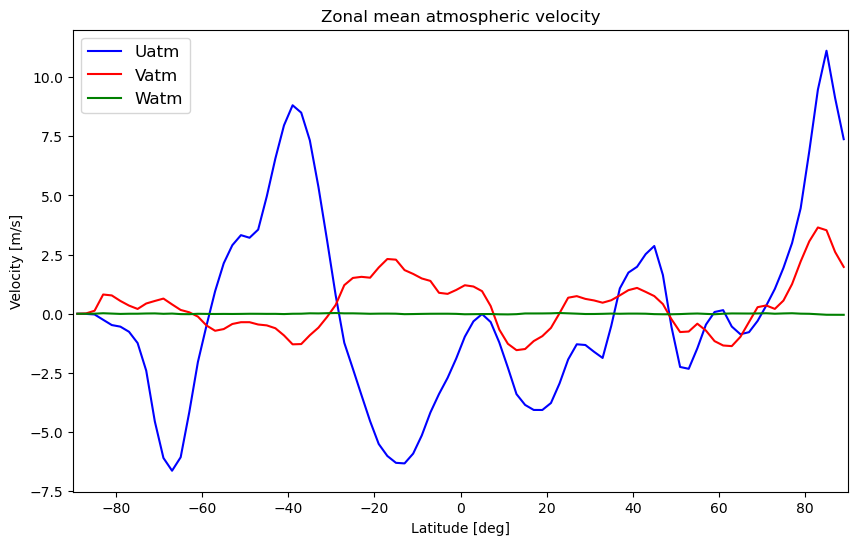

In [127]:
# Plot ocean zonal mean velocity
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)
ax.plot(lat_, Uocn_zonalmean[-1,0], label='Uocn', color='blue')
ax.plot(lat_, Vocn_zonalmean[-1,0], label='Vocn', color='red')
ax.plot(lat_, Wocn_zonalmean[-1,0], label='Wocn', color='green')
ax.set_xlim(-90, 90)
ax.set_xlabel('Latitude [deg]')
ax.set_ylabel('Velocity [m/s]') 
ax.set_title('Zonal mean ocean velocity')
ax.legend(loc='upper left', fontsize=12)    
# Plot atmospheric zonal mean velocity
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)
ax.plot(lat_, Uatm_zonalmean[-1,0], label='Uatm', color='blue')
ax.plot(lat_, Vatm_zonalmean[-1,0], label='Vatm', color='red')
ax.plot(lat_, Watm_zonalmean[-1,0], label='Watm', color='green')
ax.set_xlim(-90, 90)
ax.set_xlabel('Latitude [deg]')
ax.set_ylabel('Velocity [m/s]')
ax.set_title('Zonal mean atmospheric velocity')
ax.legend(loc='upper left', fontsize=12)        


Text(0.5, 0.98, 'Surface Current')

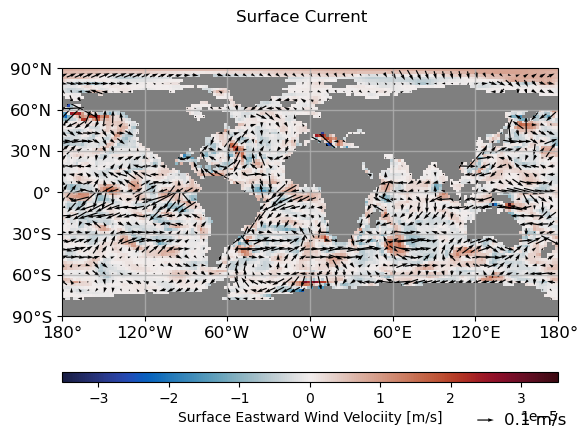

In [128]:
fig = plt.figure()
ax = plt.axes(projection=ccrs.PlateCarree())



# Umin= min(np.nanmin(Uocn_regrid),-np.nanmax(Uocn_regrid))
iter_idx = -1
depth_idx = 0
data = Wocn_regrid[iter_idx,depth_idx]
# data = Uatm_regrid[iter_idx,0]  # Choose the last time step and a specific depth index
# data = Uatm_regrid[d]

dmax = max(np.nanmax(data),-np.nanmin(data))
pc = ax.pcolormesh(lon,lat, data, vmax=dmax,vmin=-dmax, cmap=cmocean.cm.balance)
cb= fig.colorbar(pc, ax=ax, orientation="horizontal", aspect=50)
cb.set_label("Surface Eastward Wind Velociity [m/s]")

plot_pace = 3
qvU = Uocn_regrid[iter_idx,depth_idx]
qvV = Vocn_regrid[iter_idx,depth_idx]
qv = ax.quiver(
    lon[::plot_pace, ::plot_pace],
    lat[::plot_pace, ::plot_pace],
    qvU[::plot_pace, ::plot_pace],
    qvV[::plot_pace, ::plot_pace],
    pivot='mid',scale=3  
)

qk = ax.quiverkey(
    qv, 0.8, 0.125, 0.1, '0.1 m/s',
    labelpos='E', coordinates='figure',
    fontproperties={'size': 12}
)

#グリッドと軸目盛を描く緯度経度を設定するための配列
dlon,dlat=60,30
xticks=np.arange(-180,180.1,dlon)
yticks=np.arange(-90,90.1,dlat)

#グリッド線を引く
gl = ax.gridlines(crs=ccrs.PlateCarree()
         , draw_labels=False
         , linewidth=1, alpha=0.8)
gl.xlocator = mticker.FixedLocator(xticks)    
gl.ylocator = mticker.FixedLocator(yticks)
#目盛を描く緯度経度の値を設定
ax.set_xticks(xticks,crs=ccrs.PlateCarree())
ax.set_yticks(yticks,crs=ccrs.PlateCarree())

# 目盛の表示形式を度数表記にする    
latfmt=LatitudeFormatter()
lonfmt=LongitudeFormatter(zero_direction_label=True)
ax.xaxis.set_major_formatter(lonfmt)
ax.yaxis.set_major_formatter(latfmt)
#目盛のサイズを指定
ax.axes.tick_params(labelsize=12)


#mask land
mask = np.ones_like(data)*np.nan
mask[np.isnan(data)] = 0.5


ax.pcolormesh(lon, lat, mask, cmap='binary',vmax=1.0, vmin=0.0)
fig.suptitle('Surface Current')


Text(0.5, 0.98, 'Current at depth [[-3575.]] [m]')

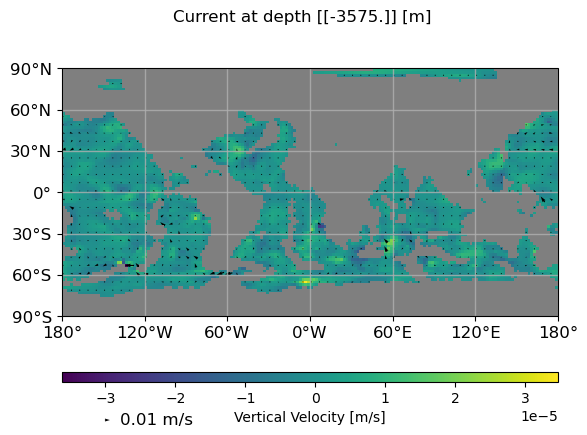

In [129]:
fig = plt.figure()
ax = plt.axes(projection=ccrs.PlateCarree())



# Umin= min(np.nanmin(Uocn_regrid),-np.nanmax(Uocn_regrid))
iter_idx = -1
depth_idx = 12
data = Wocn_regrid[iter_idx,depth_idx]

dmax = max(np.nanmax(data),-np.nanmin(data))
pc = ax.pcolormesh(lon,lat, data)
cb= fig.colorbar(pc, ax=ax, orientation="horizontal", aspect=50)
# cb.set_label("Density [kg/m$^3$]")
cb.set_label("Vertical Velocity [m/s]")

plot_pace = 3
qvU = Uocn_regrid[iter_idx,depth_idx]
qvV = Vocn_regrid[iter_idx,depth_idx]
qv = ax.quiver(
    lon[::plot_pace, ::plot_pace],
    lat[::plot_pace, ::plot_pace],
    qvU[::plot_pace, ::plot_pace],
    qvV[::plot_pace, ::plot_pace],
    pivot='mid',scale=1  # ← 適切なスケールを明示
)

qk = ax.quiverkey(
    qv, 0.2, 0.125, 0.01, '0.01 m/s',
    labelpos='E', coordinates='figure',
    fontproperties={'size': 12}
)

#グリッドと軸目盛を描く緯度経度を設定するための配列
dlon,dlat=60,30
xticks=np.arange(-180,180.1,dlon)
yticks=np.arange(-90,90.1,dlat)

#グリッド線を引く
gl = ax.gridlines(crs=ccrs.PlateCarree()
         , draw_labels=False
         , linewidth=1, alpha=0.8)
gl.xlocator = mticker.FixedLocator(xticks)    
gl.ylocator = mticker.FixedLocator(yticks)
#目盛を描く緯度経度の値を設定
ax.set_xticks(xticks,crs=ccrs.PlateCarree())
ax.set_yticks(yticks,crs=ccrs.PlateCarree())

# 目盛の表示形式を度数表記にする    
latfmt=LatitudeFormatter()
lonfmt=LongitudeFormatter(zero_direction_label=True)
ax.xaxis.set_major_formatter(lonfmt)
ax.yaxis.set_major_formatter(latfmt)
#目盛のサイズを指定
ax.axes.tick_params(labelsize=12)


#mask land
mask = np.ones_like(data)*np.nan
mask[np.isnan(data)] = 0.5
ax.pcolormesh(lon, lat, mask, cmap='binary',vmax=1.0, vmin=0.0)

fig.suptitle('Current at'+ ' depth '+str(RC_ocn[depth_idx]) + ' [m]')


<bound method Figure.tight_layout of <Figure size 640x480 with 2 Axes>>

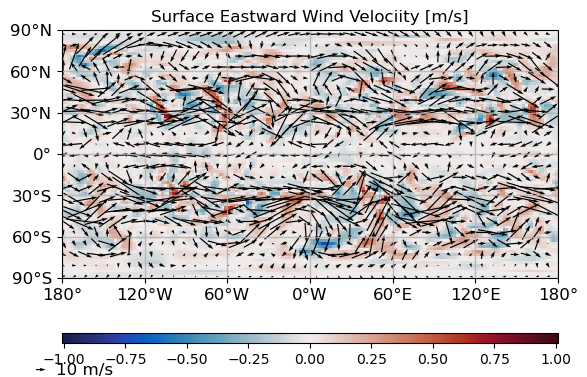

In [130]:
fig = plt.figure()
ax = plt.axes(projection=ccrs.PlateCarree())

# Umin= min(np.nanmin(Uocn_regrid),-np.nanmax(Uocn_regrid))
d=3
data = Watm_regrid[-1,d]
# data = Uatm_regrid[d]

dmax = max(np.nanmax(data),-np.nanmin(data))
pc = ax.pcolormesh(lon,lat, data, vmax=dmax,vmin=-dmax, cmap=cmocean.cm.balance)
cb= fig.colorbar(pc, ax=ax, orientation="horizontal", aspect=50)


plot_pace = 4

qv = ax.quiver(lon[::plot_pace, ::plot_pace],lat[::plot_pace,::plot_pace], Uatm_regrid[-1,d][::plot_pace,::plot_pace],Vatm_regrid[-1,d][::plot_pace,::plot_pace],scale=500, pivot='mid')
qk = ax.quiverkey(
    qv, 0.1, 0.15, 10, '10 m/s',
    labelpos='E', coordinates='figure',
    fontproperties={'size': 12}
)
                   
ax.set_title('Surface Eastward Wind Velociity [m/s]')

# カラーバーを追加
# cb = fig.colorbar(cf, ax=ax, orientation="horizontal")
# cb.set_label("Velociity [m/s]")

#グリッドと軸目盛を描く緯度経度を設定するための配列
dlon,dlat=60,30
xticks=np.arange(-180,180.1,dlon)
yticks=np.arange(-90,90.1,dlat)

#グリッド線を引く
gl = ax.gridlines(crs=ccrs.PlateCarree()
         , draw_labels=False
         , linewidth=1, alpha=0.8)
gl.xlocator = mticker.FixedLocator(xticks)    
gl.ylocator = mticker.FixedLocator(yticks)
#目盛を描く緯度経度の値を設定
ax.set_xticks(xticks,crs=ccrs.PlateCarree())
ax.set_yticks(yticks,crs=ccrs.PlateCarree())

# 目盛の表示形式を度数表記にする    
latfmt=LatitudeFormatter()
lonfmt=LongitudeFormatter(zero_direction_label=True)
ax.xaxis.set_major_formatter(lonfmt)
ax.yaxis.set_major_formatter(latfmt)
#目盛のサイズを指定
ax.axes.tick_params(labelsize=12)

fig.tight_layout



In [131]:
DP = np.array([100.e2, 250.e2, 300.e2, 200.e2,150.e2])
PF = (1000.e2 - np.cumsum(DP))/1.e2
PF = np.append(1000., PF)
PC = (PF[1:] + PF[:-1])/2.

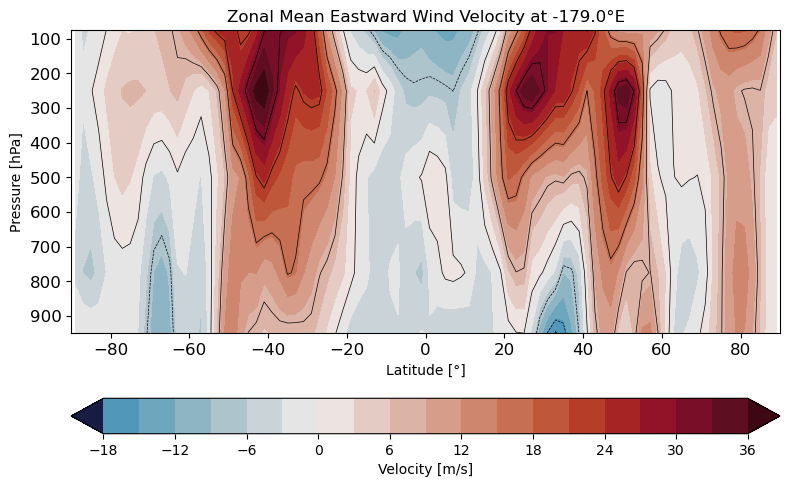

In [132]:

# Uatm_regrid_vrav: shape = (nlev, nlat)
# lat_: 緯度 (nlat,)
# PF: 高さまたは深さの座標 (nlev,)
lon_idx = 0  # 適切な経度インデックスを選択
# 2次元メッシュグリッド作成
lat2d, Z2d = np.meshgrid(lat_, PC)  # lat2d, Z2d: shape = (nlev, nlat)

# プロット
fig = plt.figure(figsize=(8, 5)) 
ax = fig.add_subplot(111)

# カラーレンジを対称に設定（ゼロ中心）
Umax = np.nanmax(np.abs(Uatm_zonalmean))

cf = ax.contourf(lat2d, Z2d, Uatm_regrid[iter_idx, :, :, lon_idx], levels=21,
                 cmap=cmocean.cm.balance,
                 vmin=-Umax, vmax=Umax, extend='both')

# pc = ax.pcolormesh(lat2d, Z2d, Uatm_regrid[iter_idx,:, :, lon_idx],
                #    cmap=cmocean.cm.balance, vmin=-Umax, vmax=Umax)
                
# 等高線を追加  
ax.contour(lat2d, Z2d, Uatm_regrid[iter_idx, :, :, lon_idx], levels=np.linspace(-Umax, Umax, 11), colors='k', linewidths=0.5)
# 軸の設定
ax.set_xlim(-90, 90)
ax.set_ylim(PC[-1], PC[0])  # 深さの順序
ax.set_title("Zonal Mean Eastward Wind Velocity at " + str(lon_[lon_idx]) + "°E")
ax.set_xlabel("Latitude [°]")
ax.set_ylabel("Pressure [hPa]")
ax.invert_yaxis()  # 深さなら下方向が深くなるように反転
ax.tick_params(labelsize=12)
# カラーバー追加
cb = fig.colorbar(cf, ax=ax, orientation="horizontal", pad=0.15)
cb.set_label("Velocity [m/s]")      

# プロットの表示
plt.tight_layout()
plt.show()      


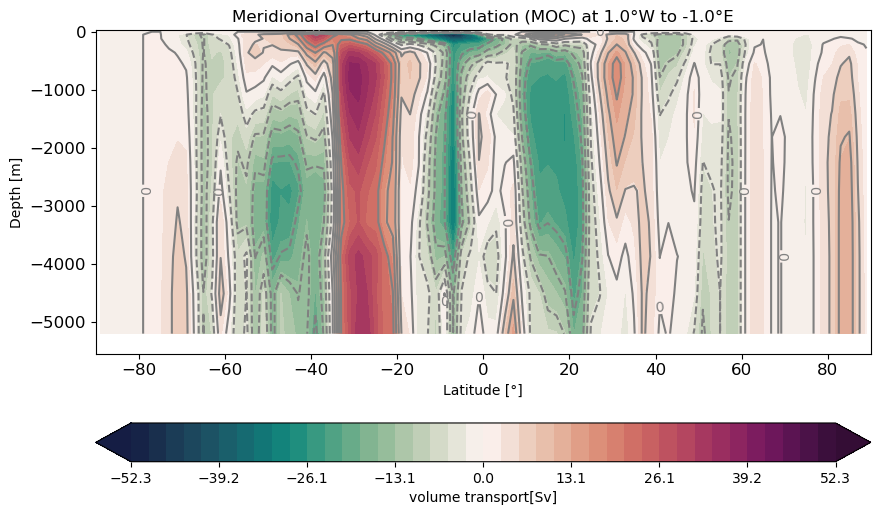

In [133]:
# norm = TwoSlopeNorm(vcenter=0.)
lon_idx_W = np.abs((lon - (0))%360).argmin()
lon_idx_E = np.abs((lon - (359))%360).argmin()
lat_mc, RF_mc = np.meshgrid(lat_, RF_ocn)
V_mc = np.nansum(Vocn_regrid[-1] * landmask_regrid * lon_distance, axis=2) # [(m/s m = m^2/s]

Phi_moc = np.zeros((len(RC_ocn)+1,len(lat_)))
for k in range(1,len(RC_ocn)+1):
    Phi_moc[k,:] = Phi_moc[k-1,:] + V_mc[k-1,:] * DRF[k-1] 


fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)

plot_data = Phi_moc *1.e-6


dmax= max(np.abs(np.nanmin(plot_data)), np.nanmax(plot_data))
cf = ax.contourf(lat_mc,RF_mc,plot_data , cmap= cmocean.cm.curl, levels= np.linspace(-dmax, dmax,41), extend='both')
cs = ax.contour(lat_mc,RF_mc,plot_data , colors= 'grey', levels= np.linspace(-20, 20,9), extend='both')
cs.clabel([0])
# ax.set_facecolor('gray')
cb = fig.colorbar(cf, orientation='horizontal')


# 陸地（nan）の部分をマスク
mask = np.ones_like(plot_data)*np.nan
mask[np.isnan(plot_data)] = 0.5
ax.pcolormesh(lat_mc, RF_mc, mask, cmap='binary', vmax=1.0, vmin=0.0)

ax.set_xlim(-90, 90)
# ax.set_ylim(RF_ocn[-1], RF_ocn[0])  # 深さの順序
# ax.invert_yaxis()  # 深さなら下方向が深くなるように反転
ax.set_title('Meridional Overturning Circulation (MOC) at ' + str(lon_[lon_idx_W]) + '°W to ' + str(lon_[lon_idx_E]) + '°E')
ax.set_xlabel('Latitude [°]')
ax.set_ylabel('Depth [m]')
ax.tick_params(labelsize=12)    
cb.set_label('volume transport[Sv]')


<>:16: SyntaxWarning: invalid escape sequence '\c'
<>:17: SyntaxWarning: invalid escape sequence '\c'
<>:16: SyntaxWarning: invalid escape sequence '\c'
<>:17: SyntaxWarning: invalid escape sequence '\c'
/tmp/ipykernel_60644/178922574.py:16: SyntaxWarning: invalid escape sequence '\c'
  ax.set_title('Salinity at' + str(lon_[lon_idx]) + '$^\circ$E')
/tmp/ipykernel_60644/178922574.py:17: SyntaxWarning: invalid escape sequence '\c'
  ax.set_xlabel('latitude[$^\circ$]')


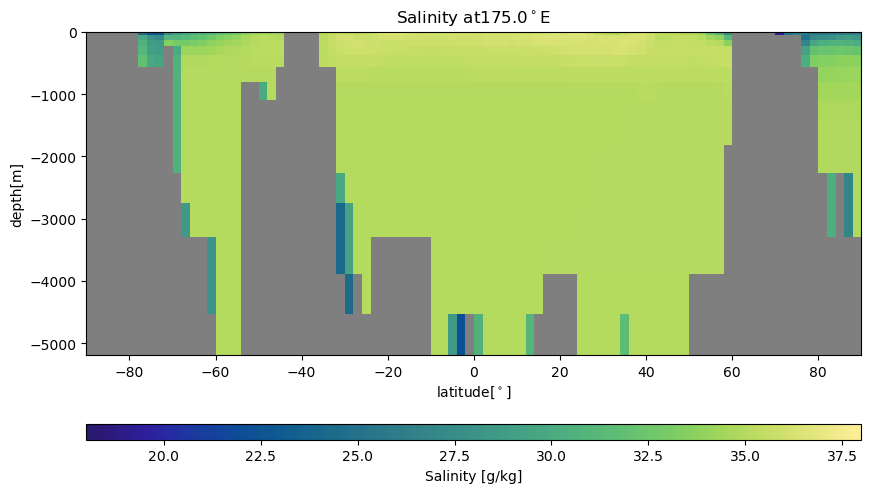

In [134]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)
lat_mc, RC_mc = np.meshgrid(lat_, RC_ocn)

Adeg = lat_distance
lon_idx = np.abs((lon - (-185))%360).argmin()
# lon_idx = np.abs((lon - (-0))%360).argmin()

   
plot_data = Socn_regrid[-1,:,:,lon_idx]
pc = ax.pcolormesh(lat_mc, RC_mc, plot_data, cmap=cmocean.cm.haline, vmin=18., vmax=38.)    
cb = fig.colorbar(pc, orientation='horizontal', aspect=50)
cb.set_label('Salinity [g/kg]')


ax.set_title('Salinity at' + str(lon_[lon_idx]) + '$^\circ$E')
ax.set_xlabel('latitude[$^\circ$]')
ax.set_ylabel('depth[m]')

#mask land
mask = np.ones_like(plot_data)*np.nan
mask[np.isnan(plot_data)] = 0.5
ax.pcolormesh(lat_mc, RC_mc, mask, cmap='binary',vmax=1.0, vmin=0.0)    

<>:12: SyntaxWarning: invalid escape sequence '\c'
<>:16: SyntaxWarning: invalid escape sequence '\c'
<>:17: SyntaxWarning: invalid escape sequence '\c'
<>:12: SyntaxWarning: invalid escape sequence '\c'
<>:16: SyntaxWarning: invalid escape sequence '\c'
<>:17: SyntaxWarning: invalid escape sequence '\c'
/tmp/ipykernel_60644/2064443339.py:12: SyntaxWarning: invalid escape sequence '\c'
  cb.set_label('Temperature $^\circ$C')
/tmp/ipykernel_60644/2064443339.py:16: SyntaxWarning: invalid escape sequence '\c'
  ax.set_title('Temperature at' + str(lon_[lon_idx]) + '$^\circ$E')
/tmp/ipykernel_60644/2064443339.py:17: SyntaxWarning: invalid escape sequence '\c'
  ax.set_xlabel('latitude[$^\circ$]')


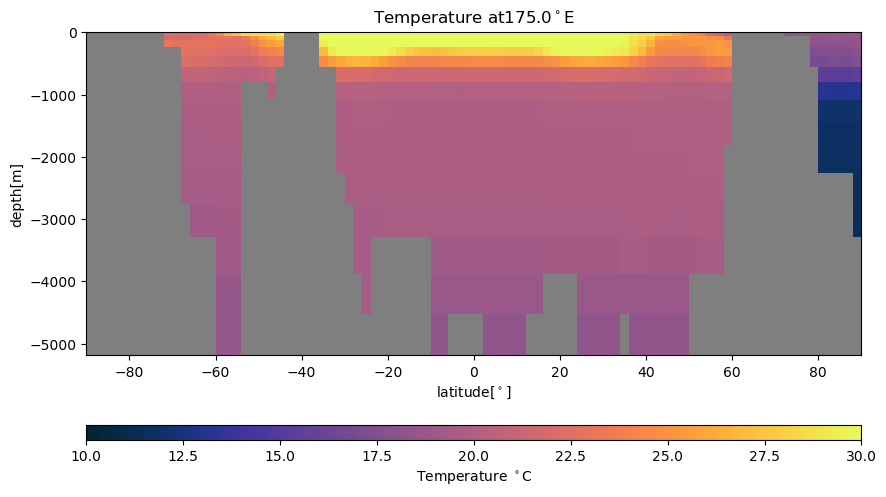

In [135]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)
lat_mc, RC_mc = np.meshgrid(lat_, RC_ocn)

Adeg = lat_distance
lon_idx = np.abs((lon - (-185))%360).argmin()
   
plot_data = Tocn_regrid[-1,:,:,lon_idx]
pc = ax.pcolormesh(lat_mc, RC_mc, plot_data, cmap=cmocean.cm.thermal, vmin=10., vmax=30.
                   )
cb= fig.colorbar(pc, orientation='horizontal', aspect=50)
cb.set_label('Temperature $^\circ$C')



ax.set_title('Temperature at' + str(lon_[lon_idx]) + '$^\circ$E')
ax.set_xlabel('latitude[$^\circ$]')
ax.set_ylabel('depth[m]')

#mask land
mask = np.ones_like(plot_data)*np.nan
mask[np.isnan(plot_data)] = 0.5
ax.pcolormesh(lat_mc, RC_mc, mask, cmap='binary',vmax=1.0, vmin=0.0)    